In [1]:
from booster import LightGBM,CatBoost
from utils import *
from sklearn.preprocessing import LabelEncoder

C:\Users\cktna\AppData\Roaming\Python\Python36\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
model1 = CatBoost()
model2 = LightGBM()

LightGBM에서 중요한 parameter:<br/>
__num_leaves, min_data_in_leaf__<br/>
__max_depth__<br/>
오버피팅 방지에 있어서 아주 중요함

# CatBoost

data = get_data('trimmed_data.csv').rename(columns={"월":"month"})

cat_pbounds = {'iterations':(100,3000),
              'learning_rate':(0.01,0.1),
              'min_data_in_leaf':(20, 100),
              'depth':(5,8),
              'max_leaves':(10,300),
              'l2_leaf_reg':(10,100),
              'border_count':(5,255)}

model1.optimize(data, cat_pbounds, init_points=10, n_iter=10)

# LightGBM

In [3]:
data = get_data('trimmed_data.csv').rename(columns={"월":"month"})

cat_vars = ['마더코드', '상품코드', '상품명', '상품군', '공휴일여부', '브랜드', 'NS상품군_대', 'NS상품군_중', 'NS상품군_소', 'prodnames', '성별', '결제방법', '세트여부', 'cluster', '일', '시간', '분', '요일', '계절',]
data2 = data[~data.로그_취급액.isna()].fillna("NA").astype(dict(zip(cat_vars, ["category" for _ in cat_vars])))
data2 = data2.assign(**{feature: LabelEncoder().fit_transform(data2[feature]) for feature in cat_vars})

lgbm_pbounds = {'num_leaves':(30,50),
               'min_data_in_leaf':(20, 100),
               'max_depth':(5,8),
                 'learning_rate':(0.05,0.1),
                'max_bin':(10,100)
               }
model1.optimize(data2, lgbm_pbounds, init_points=10, n_iter=10)

{max_bin:64.42, max_depth:5, min_data_in_leaf:20, num_leaves:50}

In [4]:
lgbm_params = {'max_bin':64, 'max_depth':5, 'min_data_in_leaf':20, 'num_leaves':50}
lgbm = LightGBM(params=lgbm_params)

LightGBM.tsCV(lgbm, data2, interval=0, verbose=True, verbose_plot=True)

1. 6월은 다른 달과 다르게 왜 null_mape가 낮은지 분석<br/>
2. null인 데이터를 예측하는데 더 좋은 모델?

# 6월의 null_mape는 왜 낮은가?

In [12]:
normal_dict = LightGBM.tsCV(lgbm, data=data2, interval=0, verbose=False, verbose_plot=False, normal=True)
null_dict = LightGBM.tsCV(lgbm, data=data2, interval=0, verbose=False, verbose_plot=False, null=True)

## 6월의 null값을 예측하는 데 중요한 feature

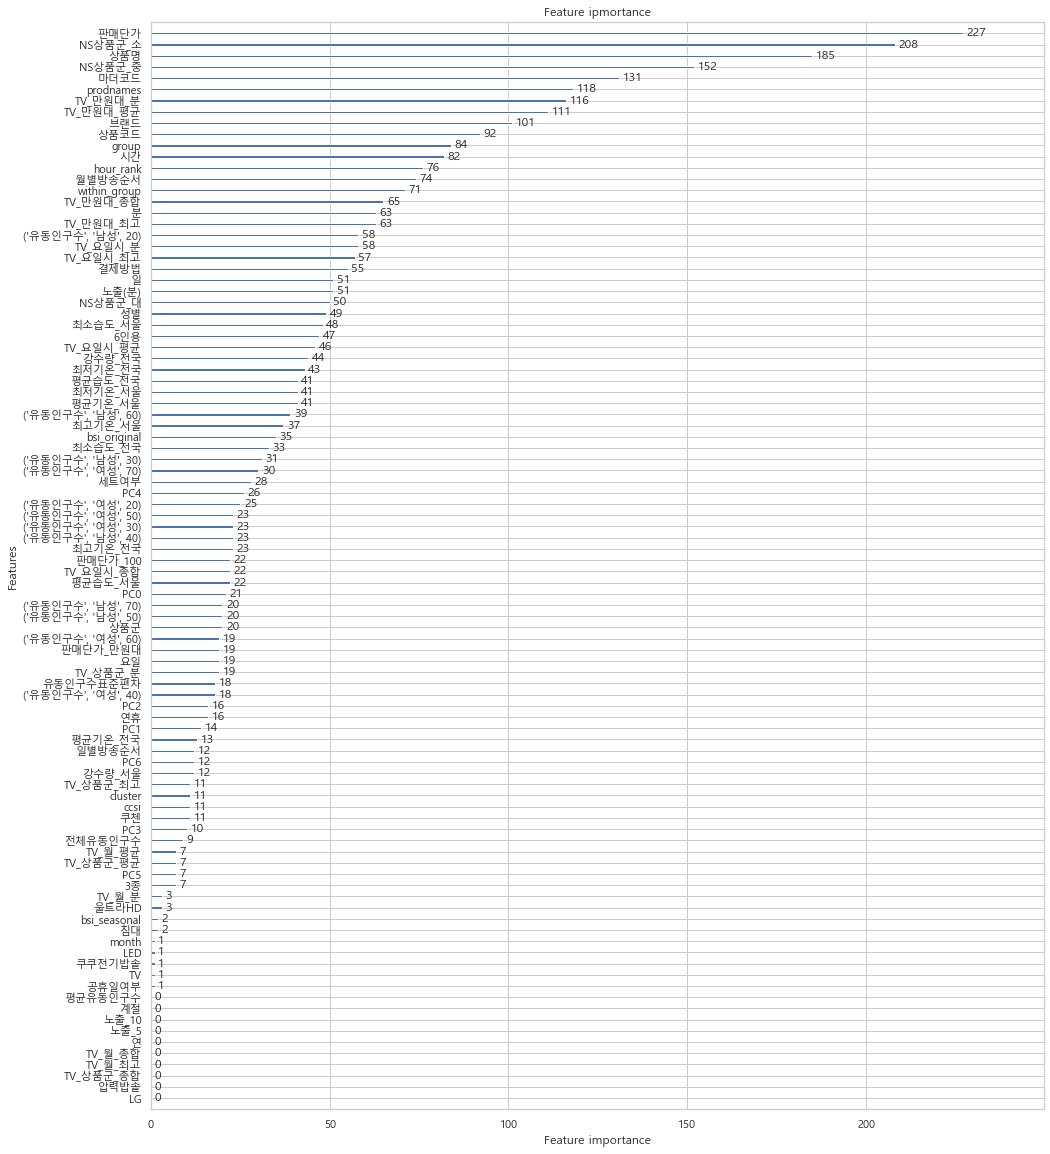

In [6]:
LightGBM.feature_impo(lgbm, data=data2, target_month=6, params=lgbm_params, isnull=True, figsize = (16, 20))

In [26]:
june_null_features = [data.columns[5], data.columns[14], data.columns[3], data.columns[13], data.columns[1], data.columns[15], data.columns[60], data.columns[61], data.columns[11], data.columns[2]]

## 6월의 normal값을 예측하는데 중요한 feature들

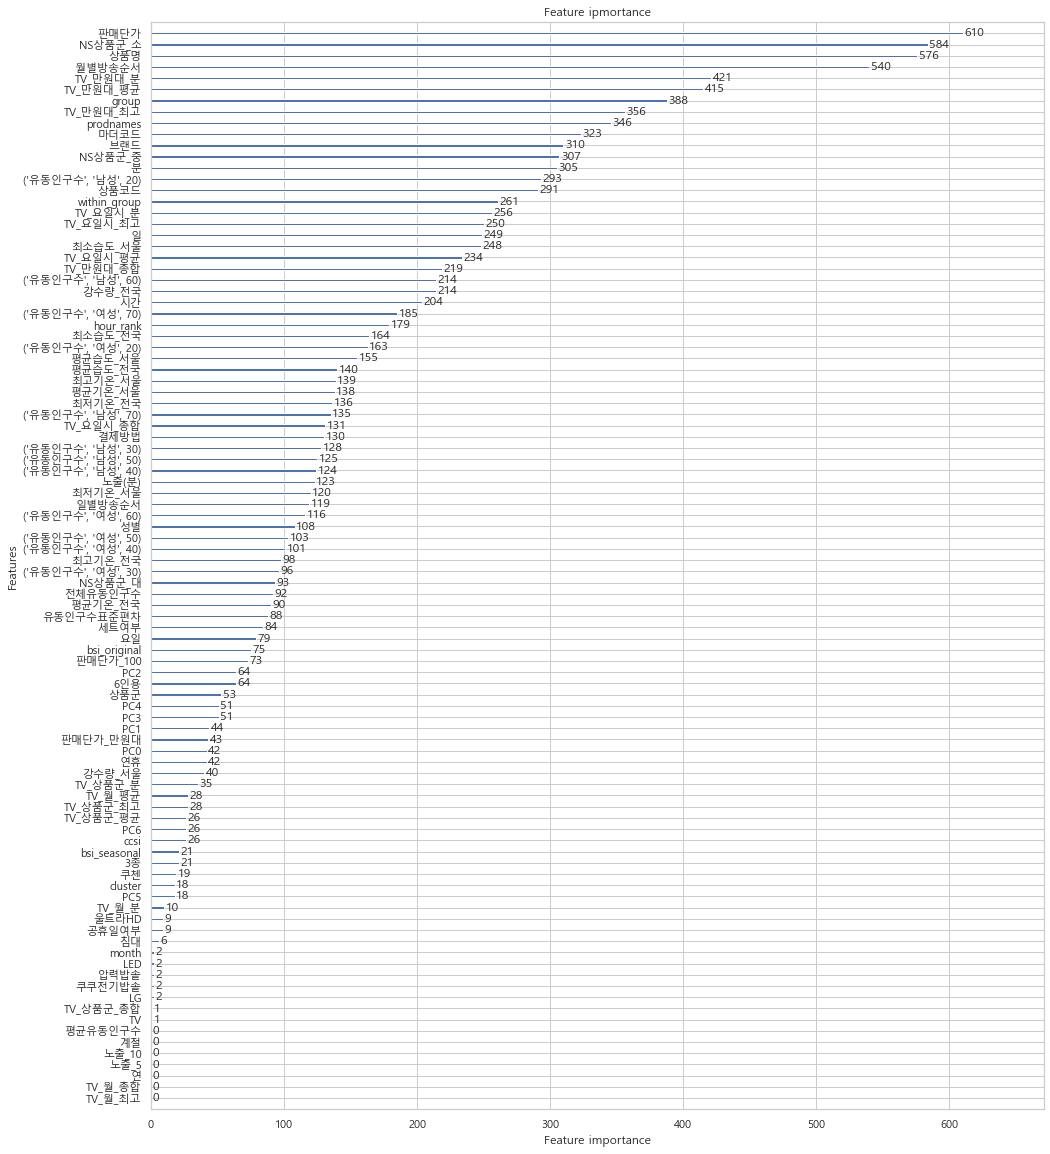

In [8]:
LightGBM.feature_impo(lgbm, data=data2, target_month=6, params=lgbm_params, isnormal=True, figsize=(16,20))

In [25]:
june_normal_features= [data.columns[5], data.columns[14], data.columns[3], data.columns[77], data.columns[60], data.columns[61], data.columns[9], data.columns[62], data.columns[15], data.columns[1]]

# 가장 null_mape가 낮은 8월과 비교

## 8월의 null값을 예측하는 데 중요한 feature들

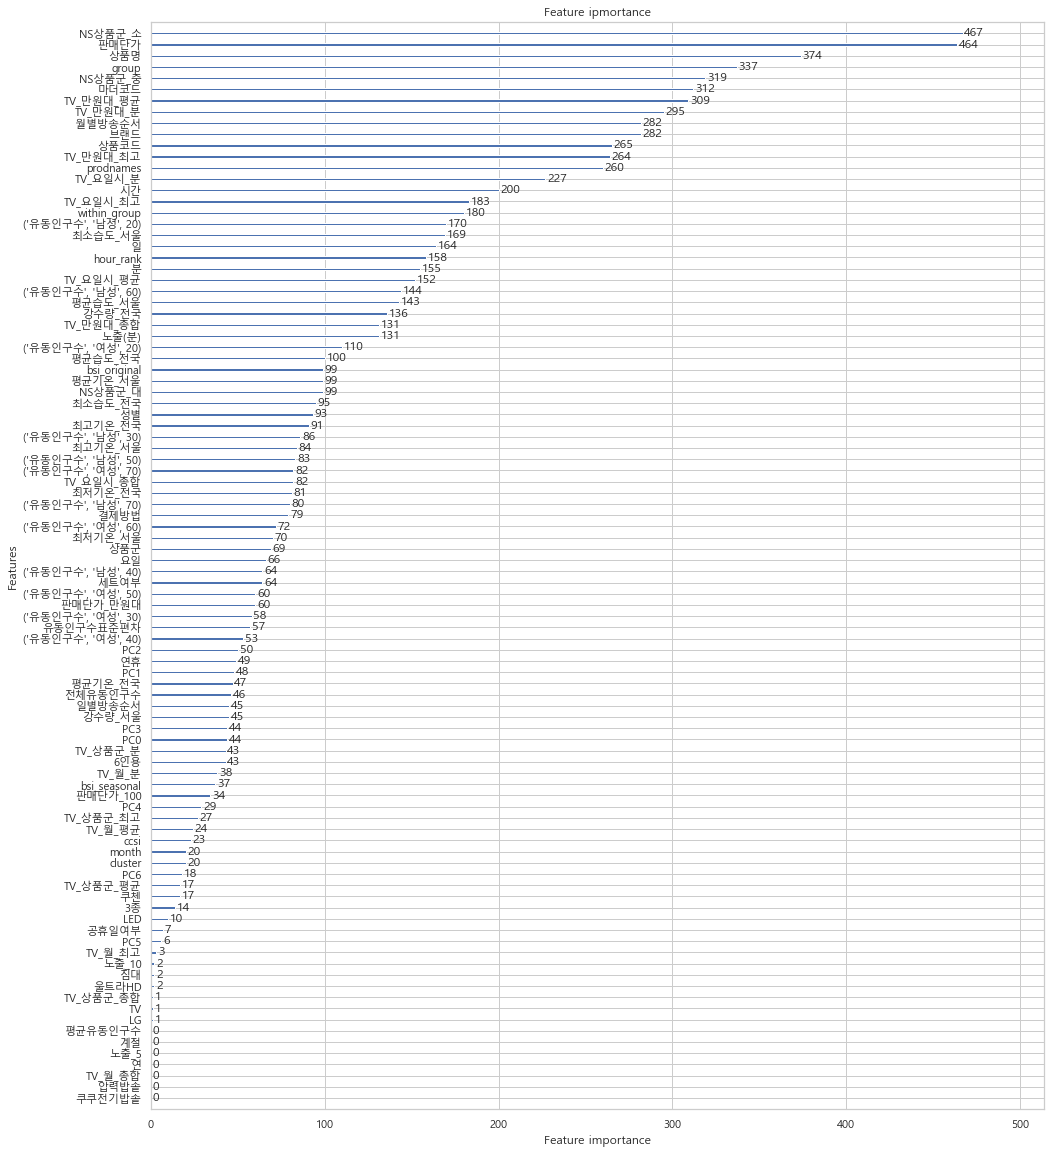

In [9]:
LightGBM.feature_impo(lgbm, data=data2, target_month=8, params=lgbm_params, isnull=True, figsize=(16,20))

In [24]:
aug_null_features = [data.columns[14], data.columns[5], data.columns[3], data.columns[9], data.columns[13], data.columns[1], data.columns[61], data.columns[60], data.columns[77], data.columns[11]]

## 8월의 normal값을 예측하는 데 중요한 feature들

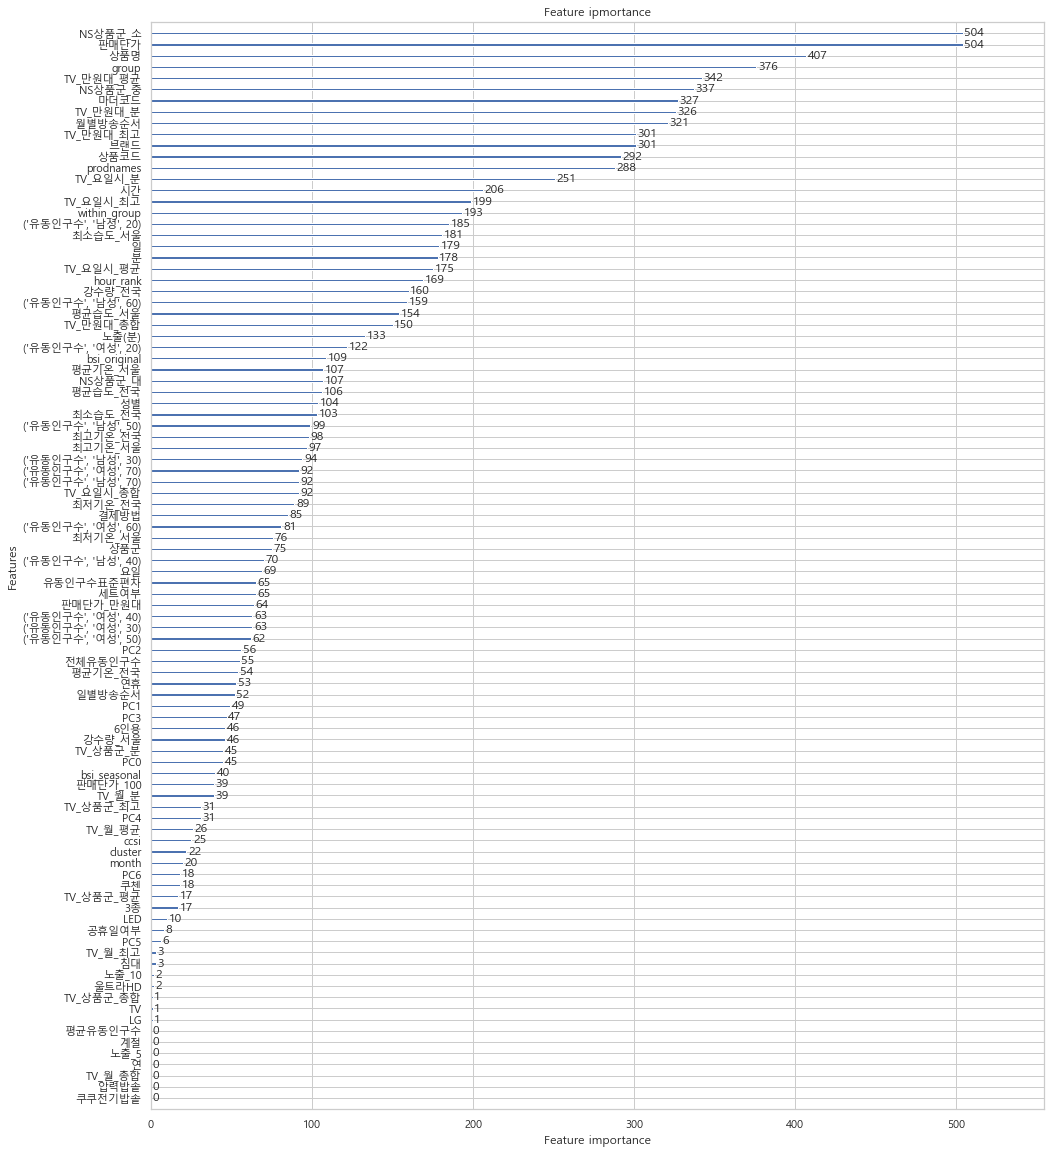

In [10]:
LightGBM.feature_impo(lgbm, data=data2, target_month=8, params=lgbm_params, isnormal=True, figsize=(16,20))

In [21]:
aug_normal_features = [data.columns[14], data.columns[5], data.columns[3], data.columns[9], data.columns[61], data.columns[13], data.columns[1], data.columns[60], data.columns[77], data.columns[62]]

In [28]:
print("June: ", set(june_normal_features) - set(june_null_features) ,"Aug: ", set(aug_normal_features) - set(aug_null_features))

{'TV_만원대_최고', 'group', '월별방송순서'}

In [36]:
print("June null - normal: ", set(june_null_features) - set(aug_null_features))

{'prodnames', '상품코드'}

In [13]:
names = ["Feb", "Mar", "Apr","May","Jun","Jul", "Aug","Sep","Oct","Nov","Dec"]
months = {}

for i in range(2,13):
    name = names[i-2]
    months[name] = data[data.index.isin(null_dict[i].index)]

In [48]:
print(len(set(june["prodnames"]) - set(data.loc[lambda x:x.month < 6]["prodnames"])),len(set(aug["prodnames"]) - set(data.loc[lambda x:x.month < 8]["prodnames"])))

67 111


In [14]:
null_data = None
for data in months:
    null_data = pd.concat([null_data, months[data]])

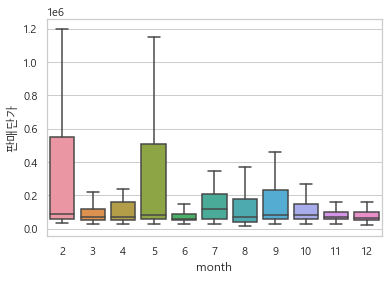

In [17]:
import seaborn as sns

sns.boxplot(x="month", y="판매단가", data= null_data, showfliers=False)

In [44]:
for i in range(2, 13):
    print(i ,":", "normal_length is ", normal_dict[i].shape[0], "and null_length is ", null_dict[i].shape[0])

2 : normal_length is  1706 and null_length is  728
3 : normal_length is  1662 and null_length is  1146
4 : normal_length is  1771 and null_length is  1013
5 : normal_length is  1458 and null_length is  1366
6 : normal_length is  1984 and null_length is  607
7 : normal_length is  1998 and null_length is  843
8 : normal_length is  1809 and null_length is  772
9 : normal_length is  1762 and null_length is  931
10 : normal_length is  1693 and null_length is  1061
11 : normal_length is  1576 and null_length is  854
12 : normal_length is  2038 and null_length is  544


In [46]:
null_data.loc[lambda x:x.month == 6]["prodnames"]

13373          썸덱스 쉬룰 데일리 백팩  종  
13374          썸덱스 쉬룰 데일리 백팩  종  
13375          썸덱스 쉬룰 데일리 백팩  종  
13392           대웅모닝컴 굿템 스탠드선풍기 대
13393           대웅모닝컴 굿템 스탠드선풍기 대
                   ...           
15933    유귀열의 The 귀한 능이 누룽지삼계탕  팩
15954     [라쉬반］FC바로셀로나 에디션 드로즈SET
15955     [라쉬반］FC바로셀로나 에디션 드로즈SET
15956          크로커다일 에어스킨 감탄브라   
15957          크로커다일 에어스킨 감탄브라   
Name: prodnames, Length: 607, dtype: object

In [15]:
june_tmp = null_data.loc[lambda x:x.month == 6]
aug_tmp = null_data.loc[lambda x:x.month == 8]

In [19]:
original = pd.read_excel("../data/train/performance.xlsx", header=1)

In [20]:
june = pd.merge(june_tmp, null_dict[6]["pred"], left_index=True, right_index=True, how="left")
june = pd.merge(june, original[["방송일시","상품코드","판매단가"]], on=["상품코드","판매단가"], how="left")
june2 = june.assign(취급액 = np.exp(june["로그_취급액"]))

In [21]:
aug = pd.merge(aug_tmp, null_dict[8]["pred"], left_index=True, right_index=True, how="left")
aug = pd.merge(aug, original[["방송일시","상품코드","판매단가"]], on=["상품코드","판매단가"], how="left")
aug2 = aug.assign(취급액 = np.exp(aug["로그_취급액"]))

Text(0.5, 1.0, '6월의 실제 취급액과 예측값 비교')

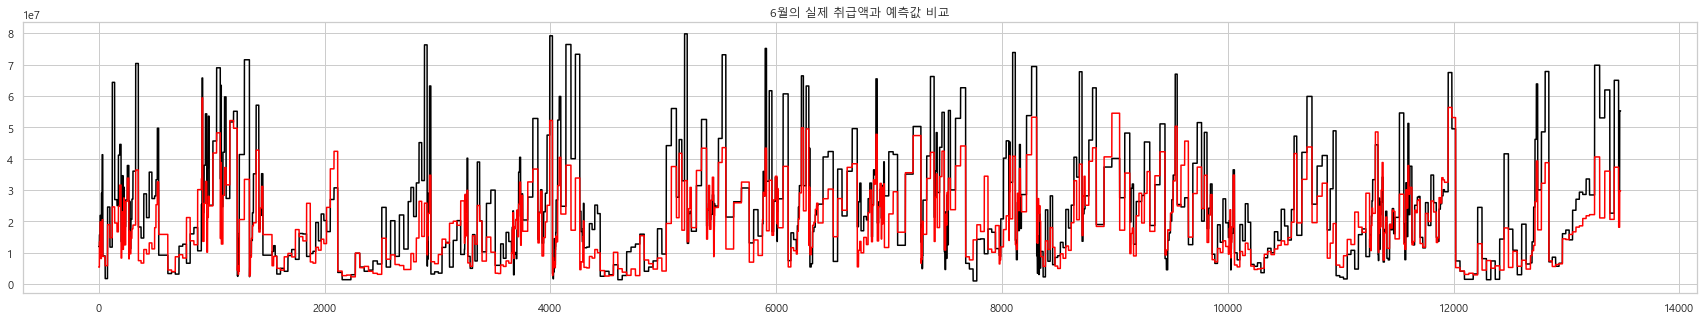

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,5))
plt.plot(june2.index, "취급액", data=june2, color="black")
plt.plot(june2.index, "pred", data=june2, color="red")
plt.title("6월의 실제 취급액과 예측값 비교")

Text(0.5, 1.0, '8월의 실제 취급액과 예측값 비교')

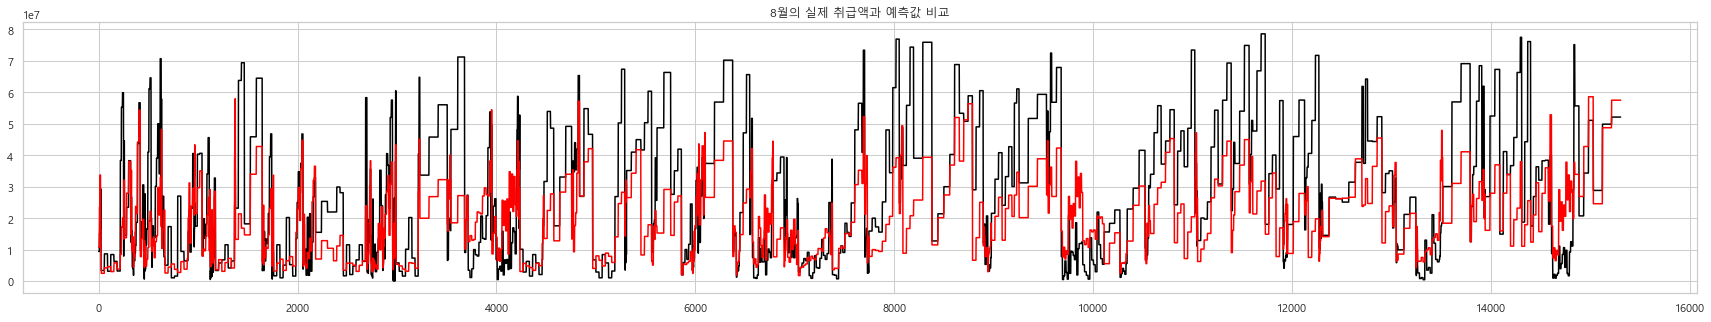

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,5))
plt.plot(aug2.index, "취급액", data=aug2, color="black")
plt.plot(aug2.index, "pred", data=aug2, color="red")
plt.title("8월의 실제 취급액과 예측값 비교")

# Null 데이터 모델링